## Dataset
First we load the dataset. We use the Meteostat API https://dev.meteostat.net/api/ to get hourly weather data for each city.

In [2]:
import requests
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from itertools import product

import json
import time

Below I set up the API key

In [ ]:
url = "https://meteostat.p.rapidapi.com/stations/hourly"

querystring = {"station":"72493","start":"2024-02-01","end":"2024-03-02","tz":"UTC"}

headers = {
	"X-RapidAPI-Key": "4b37a22715msh635f91ab90a3b1fp14bbf2jsn02151fe107f4", # this is my API key, feel free to register and use your own API key
	"X-RapidAPI-Host": "meteostat.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)

print(response.json())

{'meta': {'generated': '2024-05-05 19:09:23'}, 'data': [{'time': '2024-02-01 00:00:00', 'temp': 12.8, 'dwpt': 10.0, 'rhum': 83.0, 'prcp': 0.8, 'snow': None, 'wdir': 150.0, 'wspd': 29.5, 'wpgt': None, 'pres': 1002.9, 'tsun': None, 'coco': 8}, {'time': '2024-02-01 01:00:00', 'temp': 12.8, 'dwpt': 10.0, 'rhum': 83.0, 'prcp': 0.8, 'snow': None, 'wdir': 150.0, 'wspd': 29.5, 'wpgt': None, 'pres': 1002.3, 'tsun': None, 'coco': 8}, {'time': '2024-02-01 02:00:00', 'temp': 12.8, 'dwpt': 10.0, 'rhum': 83.0, 'prcp': 1.3, 'snow': None, 'wdir': 150.0, 'wspd': 35.3, 'wpgt': None, 'pres': 1002.3, 'tsun': None, 'coco': 9}, {'time': '2024-02-01 03:00:00', 'temp': 12.2, 'dwpt': 12.2, 'rhum': 100.0, 'prcp': 0.8, 'snow': None, 'wdir': 160.0, 'wspd': 35.3, 'wpgt': None, 'pres': 1002.4, 'tsun': None, 'coco': 9}, {'time': '2024-02-01 04:00:00', 'temp': 12.8, 'dwpt': 11.0, 'rhum': 89.0, 'prcp': 2.3, 'snow': None, 'wdir': 160.0, 'wspd': 35.3, 'wpgt': None, 'pres': 1002.4, 'tsun': None, 'coco': 9}, {'time': '202

In [ ]:
data = response.json()['data']
data

In [ ]:
from datetime import datetime, timedelta

def generate_date_ranges(start_date, end_date, delta_days=30):
    # Convert start and end date strings to datetime objects
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")

    # Initialize the current start date
    current_start = start

    # List to hold the start and end date pairs
    ranges = []

    # Loop until the current start date is less than or equal to the end date
    while current_start <= end:
        # Calculate the end date for the current period
        current_end = current_start + timedelta(days=delta_days - 1)

        # Ensure the current end date does not exceed the overall end date
        if current_end > end:
            current_end = end

        # Append the current start and end dates as strings in yyyy-mm-dd format
        ranges.append((current_start.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d")))

        # Update the current start date to the day after the current end date
        current_start = current_end + timedelta(days=1)

    return ranges

In [ ]:
# Example usage
date_ranges = generate_date_ranges("2020-01-01", "2022-12-31")
print(len(date_ranges))

37


Below I will fetch and save the data from the API, however I also provided the data in the uploaded files, therefore feel free to skip the below steps and go straight into the load section

Import SF data

In [ ]:
for start, end in date_ranges:
  querystring = {"station":"72493","start":start,"end":end,"tz":"UTC"}
  response = requests.get(url, headers=headers, params=querystring)
  time.sleep(1)
  data += response.json()['data']

In [ ]:
import json
with open('SF.json', 'w') as f:
    json.dump(data, f)

Import Fresno data

In [ ]:
data = []

In [ ]:
for start, end in date_ranges:
  querystring = {"station":"KFCH0","start":start,"end":end,"tz":"UTC"}
  response = requests.get(url, headers=headers, params=querystring)
  time.sleep(0.5)
  data += response.json()['data']

In [ ]:
with open('Fresno.json', 'w') as f:
    json.dump(data, f)

Import Palm Springs data

In [ ]:
data = []

In [ ]:
for start, end in date_ranges:
  querystring = {"station":"KPSP0","start":start,"end":end,"tz":"UTC"}
  response = requests.get(url, headers=headers, params=querystring)
  time.sleep(0.5)
  data += response.json()['data']

In [ ]:
with open('PalmSpring.json', 'w') as f:
    json.dump(data, f)

load SF data

In [3]:
f = open('SF.json')
sf_data = json.load(f)

f = open('Fresno.json')
fresno_data = json.load(f)

f = open('PalmSpring.json')
palm_spring_data = json.load(f)

Below I changed each data into pandas format

In [4]:
sf_data = [(x['time'], float(x['temp'])) for x in sf_data]

In [5]:
ps_data = []
for i in range(len(palm_spring_data)):
  if palm_spring_data[i]['temp'] is not None:
    ps_data.append((palm_spring_data[i]['time'], float(palm_spring_data[i]['temp'])))
  else:
    ps_data.append((palm_spring_data[i]['time'], None))

In [6]:
f_data = []
for i in range(len(fresno_data)):
  if fresno_data[i]['temp'] is not None:
    f_data.append((fresno_data[i]['time'], float(fresno_data[i]['temp'])))
  else:
    f_data.append((fresno_data[i]['time'], None))

A simple visualization as a quick sanity check

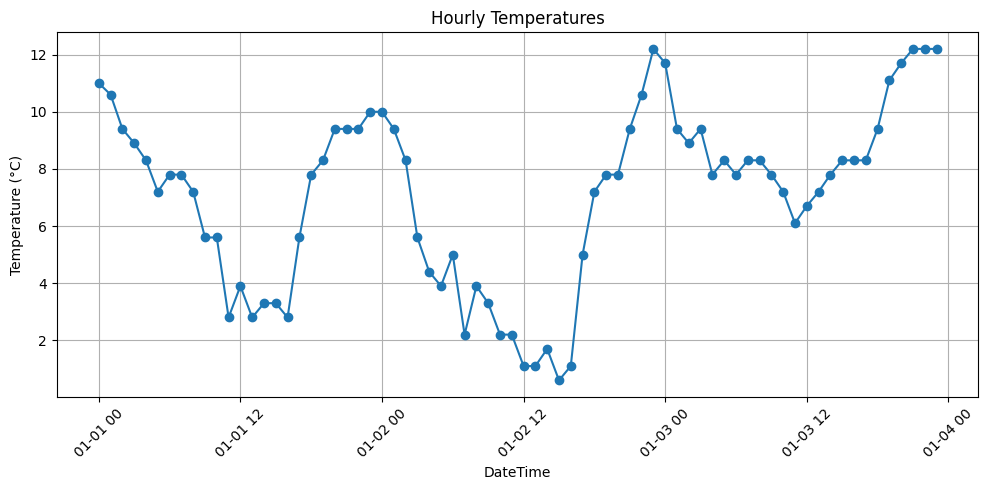

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(sf_data, columns=['DateTime', 'Temperature'])

# Step 2: Convert 'DateTime' to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Step 3: Set 'DateTime' as the index
df.set_index('DateTime', inplace=True)

df = df['2022-01-01':'2022-01-03']

# Step 4: Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Temperature'], marker='o', linestyle='-')
plt.title('Hourly Temperatures')
plt.xlabel('DateTime')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

Add Palm Spring, Fresno and SF Data

In [7]:
ps_df = pd.DataFrame(ps_data, columns=['DateTime', 'Temperature'])

# Step 2: Convert 'DateTime' to datetime type
ps_df['DateTime'] = pd.to_datetime(ps_df['DateTime'])

# Step 3: Set 'DateTime' as the index
ps_df.set_index('DateTime', inplace=True)

# Step 4: Replace None values with the previous value (forward fill)
ps_df['Temperature'].fillna(method='ffill', inplace=True)
ps_df

,Temperature
DateTime,
2020-01-01 00:00:00,NaN
2020-01-01 01:00:00,17.8
2020-01-01 02:00:00,16.7
2020-01-01 03:00:00,15.6
2020-01-01 04:00:00,13.9
...,...
2022-12-31 19:00:00,12.8
2022-12-31 20:00:00,12.8
2022-12-31 21:00:00,13.9


In [8]:
fresno_df = pd.DataFrame(f_data, columns=['DateTime', 'Temperature'])

# Step 2: Convert 'DateTime' to datetime type
fresno_df['DateTime'] = pd.to_datetime(fresno_df['DateTime'])

# Step 3: Set 'DateTime' as the index
fresno_df.set_index('DateTime', inplace=True)

# Step 4: Replace None values with the previous value (forward fill)
fresno_df['Temperature'].fillna(method='ffill', inplace=True)
fresno_df

,Temperature
DateTime,
2020-01-01 00:00:00,NaN
2020-01-01 01:00:00,NaN
2020-01-01 02:00:00,NaN
2020-01-01 03:00:00,NaN
2020-01-01 04:00:00,NaN
...,...
2022-12-31 19:00:00,15.0
2022-12-31 20:00:00,15.1
2022-12-31 21:00:00,14.4


In [9]:
sf_df = pd.DataFrame(sf_data, columns=['DateTime', 'Temperature'])

# Step 2: Convert 'DateTime' to datetime type
sf_df['DateTime'] = pd.to_datetime(sf_df['DateTime'])

# Step 3: Set 'DateTime' as the index
sf_df.set_index('DateTime', inplace=True)

# Step 4: Replace None values with the previous value (forward fill)
sf_df['Temperature'].fillna(method='ffill', inplace=True)
sf_df

,Temperature
DateTime,
2020-01-01 00:00:00,15.0
2020-01-01 01:00:00,15.0
2020-01-01 02:00:00,12.2
2020-01-01 03:00:00,10.0
2020-01-01 04:00:00,10.0
...,...
2022-12-31 19:00:00,12.8
2022-12-31 20:00:00,12.2
2022-12-31 21:00:00,11.1


In [13]:
daily_df = sf_df.resample('D').mean()

min_temp = daily_df['Temperature'].min()
max_temp = daily_df['Temperature'].max()
daily_df['Temperature'] = (daily_df['Temperature'] - min_temp) / (max_temp - min_temp)

train = daily_df['2022-01-01':'2022-05-31']
test = daily_df['2022-06-01':'2022-07-01']

## Statistical Model

### ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


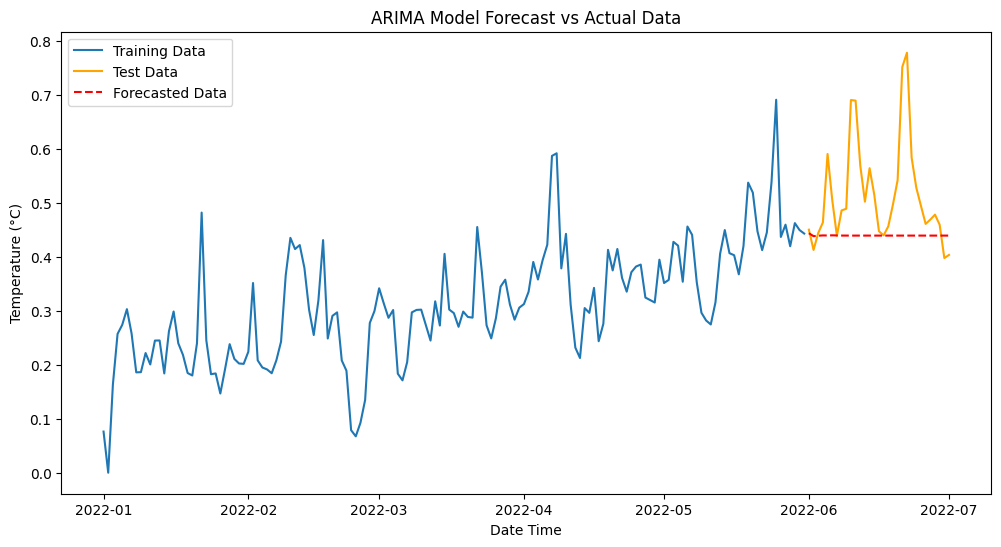

In [14]:
# Fitting an ARIMA model on the training data
model = ARIMA(train, order=(5, 1, 1))
fitted_model = model.fit()

# Forecasting the next 48 hours (2 days * 24 hours)
forecast = fitted_model.get_forecast(steps=31)
forecast_index = pd.date_range(start='6/1/2022', periods=31, freq='D')
forecast_mean = forecast.summary_frame()['mean']

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Training Data')
plt.plot(test.index, test['Temperature'], label='Test Data', color='orange')
plt.plot(forecast_index, forecast_mean, label='Forecasted Data', color='red', linestyle='--')
plt.title('ARIMA Model Forecast vs Actual Data')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

we then get the MAE (mean absolute error)

In [15]:
print(np.sum(np.absolute((forecast_mean.astype("float") - test['Temperature'].astype("float")))) / len(forecast_mean))

0.08336495344327643


Here we sample daily temp for palm spring and fresno

In [20]:
daily_df_ps = ps_df.resample('D').mean()

min_temp = daily_df_ps['Temperature'].min()
max_temp = daily_df_ps['Temperature'].max()
daily_df_ps['Temperature'] = (daily_df_ps['Temperature'] - min_temp) / (max_temp - min_temp)

train_ps = daily_df_ps['2022-01-01':'2022-05-31']
test_ps = daily_df_ps['2022-06-01':'2022-07-01']

In [21]:
daily_df_fresno = fresno_df.resample('D').mean()

min_temp = daily_df_fresno['Temperature'].min()
max_temp = daily_df_fresno['Temperature'].max()
daily_df_fresno['Temperature'] = (daily_df_fresno['Temperature'] - min_temp) / (max_temp - min_temp)

train_fresno = daily_df_fresno['2022-01-01':'2022-05-31']
test_fresno = daily_df_fresno['2022-06-01':'2022-07-01']

### SARIMAX

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


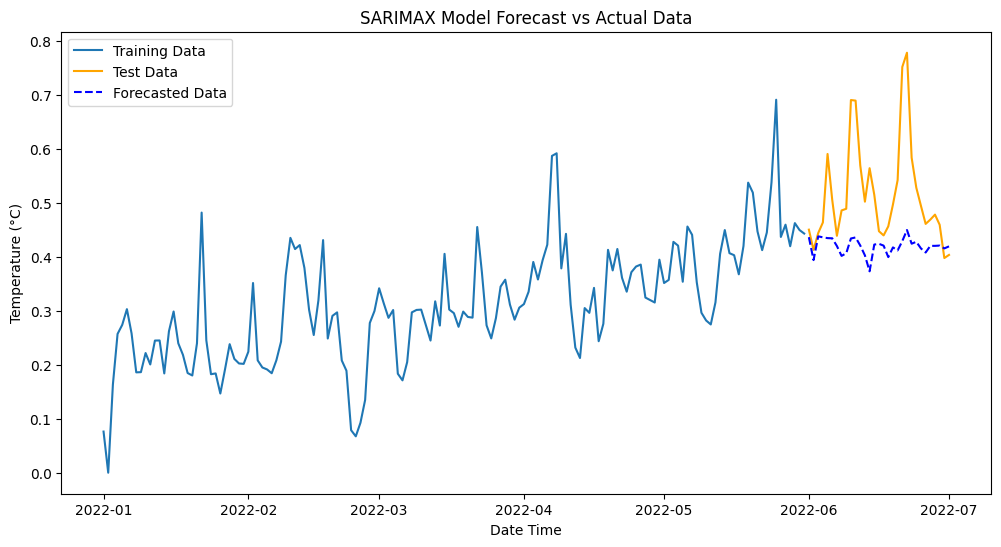

In [16]:

# Forecasting the next 48 hours (2 days * 24 hours)
# forecast = fitted_model.get_forecast(exog=test_ps['Temperature'], steps=31)
forecast_index = pd.date_range(start='6/1/2022', periods=31, freq='D')
# forecast_mean = forecast.summary_frame()['mean']

fitted_model_2 = SARIMAX(train, order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()
forecast_2 = fitted_model_2.get_forecast(steps=31)
forecast_mean_2 = forecast_2.summary_frame()['mean']


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Training Data')
plt.plot(test.index, test['Temperature'], label='Test Data', color='orange')
# plt.plot(forecast_index, forecast_mean, label='Forecasted Data w/ PS', color='red', linestyle='--')
plt.plot(forecast_index, forecast_mean_2, label='Forecasted Data', color='blue', linestyle='--')
plt.title('SARIMAX Model Forecast vs Actual Data')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()

In [18]:
print("MAE for single city sarimax: {}".format(np.sum(np.absolute((forecast_mean_2.astype("float") - test['Temperature'].astype("float")))) / len(forecast_mean)))

MAE for single city sarimax: 0.09849195363548863


We calculate the lagged version of fresno and palm spring data

In [22]:
train_fresno_lagged = daily_df_fresno['2021-12-31':'2022-05-31'].shift(1).dropna()
test_fresno_lagged = daily_df_fresno['2022-05-31':'2022-07-01'].shift(1).dropna()

train_ps_lagged = daily_df_ps['2021-12-31':'2022-05-31'].shift(1).dropna()
test_ps_lagged = daily_df_ps['2022-05-31':'2022-07-01'].shift(1).dropna()

Now we add in another city (Fresno) to predict SF temperature

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


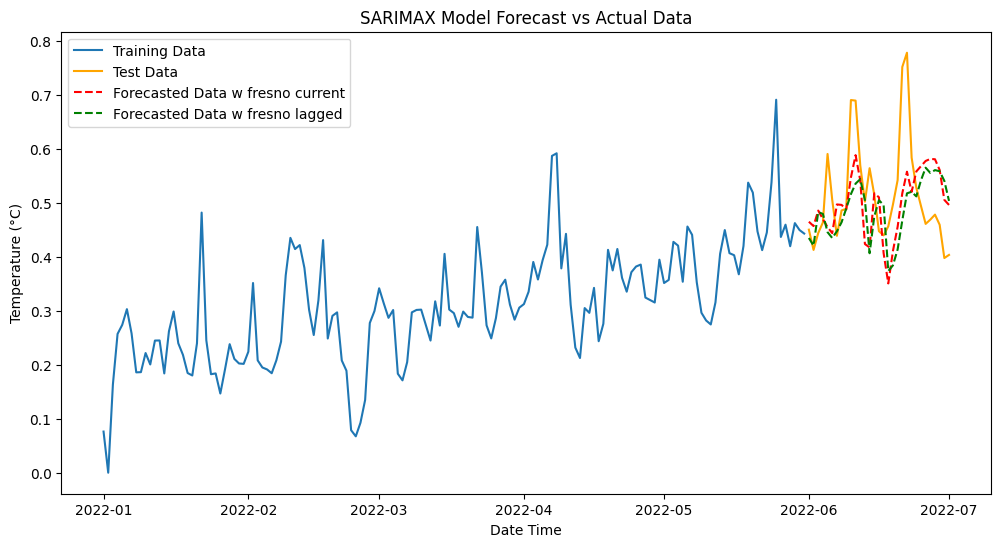

In [23]:
# Fitting an ARIMA model on the training data
fitted_model = SARIMAX(train, exog=train_fresno['Temperature'], order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()

# Forecasting the next 48 hours (2 days * 24 hours)
forecast = fitted_model.get_forecast(exog=test_fresno['Temperature'], steps=31)
forecast_index = pd.date_range(start='6/1/2022', periods=31, freq='D')
forecast_mean = forecast.summary_frame()['mean']

fitted_model_2 = SARIMAX(train, order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()
forecast_2 = fitted_model_2.get_forecast(steps=31)
forecast_mean_2 = forecast_2.summary_frame()['mean']


fitted_model_3 = SARIMAX(train, exog=train_fresno_lagged['Temperature'], order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()
forecast_3 = fitted_model_3.get_forecast(exog=test_fresno_lagged['Temperature'], steps=31)
forecast_mean_3 = forecast_3.summary_frame()['mean']

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Training Data')
plt.plot(test.index, test['Temperature'], label='Test Data', color='orange')
plt.plot(forecast_index, forecast_mean, label='Forecasted Data w fresno current', color='red', linestyle='--')
# plt.plot(forecast_index, forecast_mean_2, label='Forecasted Data w/o fresno', color='blue', linestyle='--')
plt.plot(forecast_index, forecast_mean_3, label='Forecasted Data w fresno lagged', color='green', linestyle='--')
plt.title('SARIMAX Model Forecast vs Actual Data')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()

Now we use both city (Palm Spring and Fresno) to predict SF temperature

In [24]:
train_both = train_ps.join(train_fresno, how='outer', lsuffix='_ps', rsuffix='_fresno')
test_both = test_ps.join(test_fresno, how='outer', lsuffix='_ps', rsuffix='_fresno')

In [25]:
train_both_lagged = train_ps_lagged.join(train_fresno_lagged, how='outer', lsuffix='_ps', rsuffix='_fresno')
test_both_lagged = test_ps_lagged.join(test_fresno_lagged, how='outer', lsuffix='_ps', rsuffix='_fresno')

In [27]:
train_both.head(5)

,Temperature_ps,Temperature_fresno
DateTime,,
2022-01-01,0.232999,0.039967
2022-01-02,0.102186,0.034207
2022-01-03,0.078029,0.050429
2022-01-04,0.123082,0.088163
2022-01-05,0.178524,0.111908


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


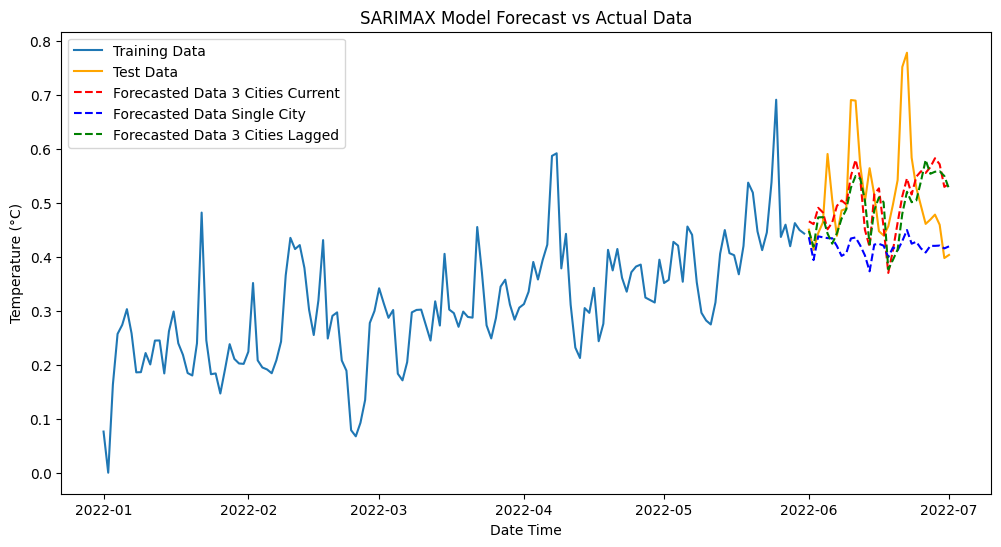

In [28]:
# Fitting an ARIMA model on the training data
fitted_model = SARIMAX(train, exog=train_both[['Temperature_ps', 'Temperature_fresno']], order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()

# Forecasting the next 48 hours (2 days * 24 hours)
forecast = fitted_model.get_forecast(exog=test_both[['Temperature_ps', 'Temperature_fresno']], steps=31)
forecast_index = pd.date_range(start='6/1/2022', periods=31, freq='D')
forecast_mean = forecast.summary_frame()['mean']

fitted_model_2 = SARIMAX(train, order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()
forecast_2 = fitted_model_2.get_forecast(steps=31)
forecast_mean_2 = forecast_2.summary_frame()['mean']

fitted_model_3 = SARIMAX(train, exog=train_both_lagged[['Temperature_ps', 'Temperature_fresno']], order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()
forecast_3 = fitted_model_3.get_forecast(exog=test_both_lagged[['Temperature_ps', 'Temperature_fresno']], steps=31)
forecast_mean_3 = forecast_3.summary_frame()['mean']


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Temperature'], label='Training Data')
plt.plot(test.index, test['Temperature'], label='Test Data', color='orange')
plt.plot(forecast_index, forecast_mean, label='Forecasted Data 3 Cities Current', color='red', linestyle='--')
plt.plot(forecast_index, forecast_mean_2, label='Forecasted Data Single City', color='blue', linestyle='--')
plt.plot(forecast_index, forecast_mean_3, label='Forecasted Data 3 Cities Lagged', color='green', linestyle='--')
plt.title('SARIMAX Model Forecast vs Actual Data')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()

In [29]:
print("MAE for 3 cities current sarimax: {}".format(np.sum(np.absolute((forecast_mean.astype("float") - test['Temperature'].astype("float")))) / len(forecast_mean)))
print("MAE for single city sarimax: {}".format(np.sum(np.absolute((forecast_mean_2.astype("float") - test['Temperature'].astype("float")))) / len(forecast_mean)))
print("MAE for 3 cities lagged sarimax: {}".format(np.sum(np.absolute((forecast_mean_3.astype("float") - test['Temperature'].astype("float")))) / len(forecast_mean)))

MAE for 3 cities current sarimax: 0.0809532874866438
MAE for single city sarimax: 0.09849195363548863
MAE for 3 cities lagged sarimax: 0.08292394724802662


### VAR

we first combine every data into 1 dataframe

In [30]:
train_all = train.join(train_both, how='outer')
test_all = test.join(test_both, how='outer')

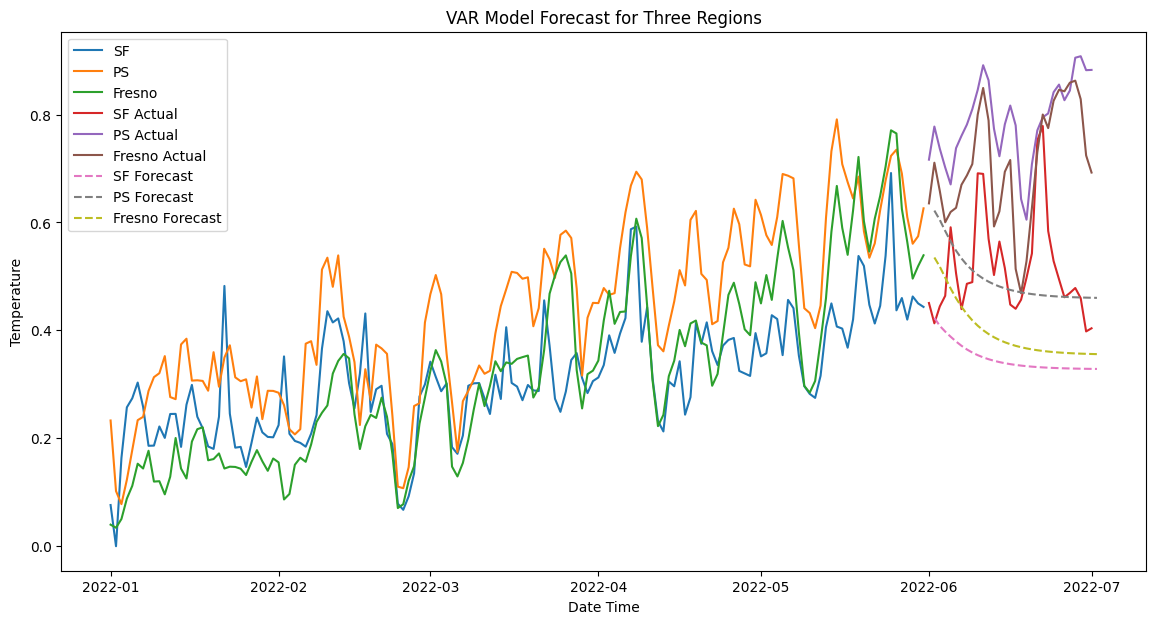

In [31]:
# Fit VAR Model
model = VAR(train_all)
fitted_model = model.fit(maxlags=29, ic='aic')  # 'aic' for Akaike Information Criterion to select optimal lag

# Forecasting
forecast_steps = 31
forecasted_values = fitted_model.forecast(y=train_all.values[-29:], steps=forecast_steps)
forecast_index = pd.date_range(start=test_all.index[0], periods=forecast_steps+1, freq='D')[1:]
forecast_df = pd.DataFrame(forecasted_values, index=forecast_index, columns=['Region1', 'Region2', 'Region3'])

# Plotting the forecast
plt.figure(figsize=(14, 7))
plt.plot(train_all.index, train_all['Temperature'], label='SF')
plt.plot(train_all.index, train_all['Temperature_ps'], label='PS')
plt.plot(train_all.index, train_all['Temperature_fresno'], label='Fresno')
plt.plot(test_all.index, test_all['Temperature'], label='SF Actual')
plt.plot(test_all.index, test_all['Temperature_ps'], label='PS Actual')
plt.plot(test_all.index, test_all['Temperature_fresno'], label='Fresno Actual')
plt.plot(forecast_df.index, forecast_df['Region1'], label='SF Forecast', linestyle='--')
plt.plot(forecast_df.index, forecast_df['Region2'], label='PS Forecast', linestyle='--')
plt.plot(forecast_df.index, forecast_df['Region3'], label='Fresno Forecast', linestyle='--')
plt.title('VAR Model Forecast for Three Regions')
plt.xlabel('Date Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [32]:
print("MAE for VAR: {}".format(np.sum(np.absolute((forecast_df['Region1'].astype("float") - test_all['Temperature'].astype("float")))) / len(forecast_mean)))

MAE for VAR: 0.16487106811170144


### SARIMAX for precipitation forecast

In [33]:
df_chicago = pd.read_csv('chicago.csv')

In [34]:
df_cleveland = pd.read_csv('cleveland.csv')

In [35]:
df_detroit = pd.read_csv('detroit.csv')

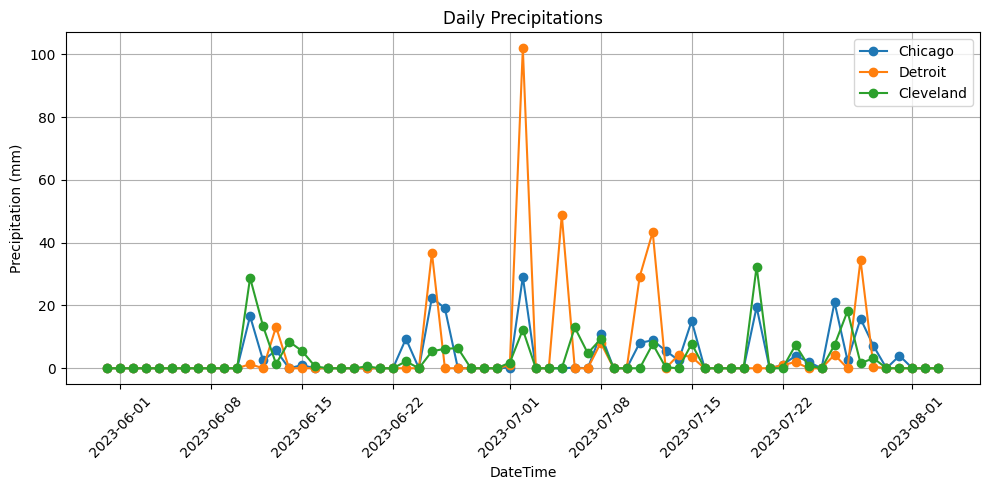

In [36]:
df = pd.DataFrame(df_detroit, columns=['date', 'prcp'])

# Step 2: Convert 'DateTime' to datetime type
df['DateTime'] = pd.to_datetime(df['date'])

# Step 3: Set 'DateTime' as the index
df.set_index('DateTime', inplace=True)

df = df['2023-05-31':'2023-8-03']

df_2 = pd.DataFrame(df_chicago, columns=['date', 'prcp'])

# Step 2: Convert 'DateTime' to datetime type
df_2['DateTime'] = pd.to_datetime(df_2['date'])

# Step 3: Set 'DateTime' as the index
df_2.set_index('DateTime', inplace=True)

df_2 = df_2['2023-5-31':'2023-8-03']

df_3 = pd.DataFrame(df_cleveland, columns=['date', 'prcp'])

# Step 2: Convert 'DateTime' to datetime type
df_3['DateTime'] = pd.to_datetime(df_3['date'])

# Step 3: Set 'DateTime' as the index
df_3.set_index('DateTime', inplace=True)

df_3 = df_3['2023-5-31':'2023-8-03']


# Step 4: Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['prcp'], marker='o', linestyle='-', label='Chicago')
plt.plot(df_2.index, df_2['prcp'], marker='o', linestyle='-', label='Detroit')
plt.plot(df_3.index, df_3['prcp'], marker='o', linestyle='-', label='Cleveland')

plt.title('Daily Precipitations')
plt.xlabel('DateTime')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.legend()
plt.show()

In [37]:
min_prcp = df_2['prcp'].min()
max_prcp = df_2['prcp'].max()
df_2['prcp'] = (df_2['prcp'] - min_prcp) / (max_prcp - min_prcp)

min_prcp = df['prcp'].min()
max_prcp = df['prcp'].max()
df['prcp'] = (df['prcp'] - min_prcp) / (max_prcp - min_prcp)

min_prcp = df_3['prcp'].min()
max_prcp = df_3['prcp'].max()
df_3['prcp'] = (df_3['prcp'] - min_prcp) / (max_prcp - min_prcp)

In [38]:
train_detroit = df['2023-06-01':'2023-7-10']
test_detroit = df['2023-07-11':'2023-8-03']

train_chicago = df_2['2023-06-01':'2023-7-10']
test_chicago = df_2['2023-07-11':'2023-8-03']

train_cleveland = df_3['2023-06-01':'2023-7-10']
test_cleveland = df_3['2023-07-11':'2023-8-03']

In [39]:
train_both = train_chicago.join(train_cleveland, how='outer', lsuffix='_chicago', rsuffix='_cleveland')
test_both = test_chicago.join(test_cleveland, how='outer', lsuffix='_chicago', rsuffix='_cleveland')

In [40]:
lag_prcp_train = df_2['2023-05-31':'2023-7-10']['prcp'].shift(1).dropna()

In [41]:
lag_prcp_test = df_2['2023-07-10':'2023-8-03']['prcp'].shift(1).dropna()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Valu

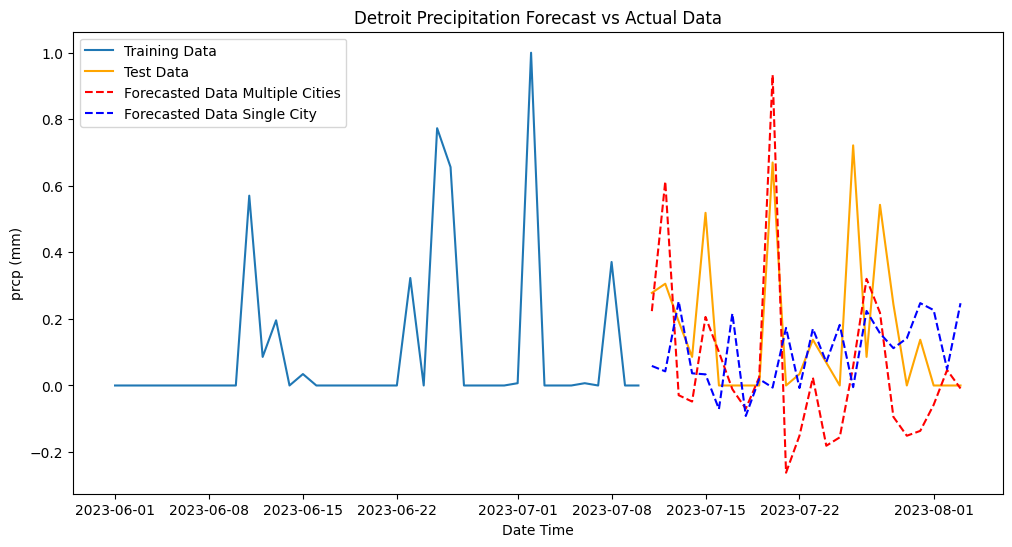

In [42]:
# Fitting an ARIMA model on the training data
fitted_model = SARIMAX(train_detroit['prcp'], exog=train_both[['prcp_chicago', 'prcp_cleveland']], order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()

# Forecasting the next 48 hours (2 days * 24 hours)
forecast = fitted_model.get_forecast(exog=test_both[['prcp_chicago', 'prcp_cleveland']], steps=24)
forecast_index = pd.date_range(start='7/11/2023', periods=24, freq='D')
forecast_mean = forecast.summary_frame()['mean']

fitted_model_2 = SARIMAX(train_detroit['prcp'], order=(1,1,2), seasonal_order=(3, 0, 6, 4)).fit()
forecast_2 = fitted_model_2.get_forecast(steps=24)
forecast_mean_2 = forecast_2.summary_frame()['mean']

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_detroit.index, train_detroit['prcp'], label='Training Data')
plt.plot(test_detroit.index, test_detroit['prcp'], label='Test Data', color='orange')
plt.plot(forecast_index, forecast_mean, label='Forecasted Data Multiple Cities', color='red', linestyle='--')
plt.plot(forecast_index, forecast_mean_2, label='Forecasted Data Single City', color='blue', linestyle='--')
plt.title('Detroit Precipitation Forecast vs Actual Data')
plt.xlabel('Date Time')
plt.ylabel('prcp (mm)')
plt.legend()

In [43]:
print("MAE for 3 cities sarimax: {}".format(np.sum(np.absolute((forecast_mean.astype("float") - test_detroit['prcp'].astype("float")))) / len(forecast_mean)))
print("MAE for single city sarimax: {}".format(np.sum(np.absolute((forecast_mean_2.astype("float") - test_detroit['prcp'].astype("float")))) / len(forecast_mean)))

MAE for 3 cities sarimax: 0.19030438320597254
MAE for single city sarimax: 0.19760179451320273


## Machine Learning Models

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import torch

we scale all temperature to between 0-1 for ML models to avoid gradient explosion/vanishing

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
sf_df['Temperature'] = scaler.fit_transform(sf_df['Temperature'].values.reshape(-1, 1))

In [12]:
# Convert data to sequences for LSTM input
def create_sequences(data, input_length, prediction_length):
    xs = []
    ys = []
    for i in range(len(data) - input_length - prediction_length + 1):
        x = data.iloc[i:(i + input_length)].values
        y = data.iloc[(i + input_length):(i + input_length + prediction_length)].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 48
prediction_length = 1

# Split data into training and testing sets (e.g., last 24*30 for testing)
test_size = 24 * 30  # 30 days
train_data = sf_df[:-test_size]
test_data = sf_df[-test_size:]

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, input_length, prediction_length)
X_test, y_test = create_sequences(test_data, input_length, prediction_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=120, shuffle=False)

In [13]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim2, pred_len=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.pred_len = pred_len
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to('cuda')

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to('cuda')

        out, (hn, cn) = self.lstm(x, (h0,c0))

        # Index hidden state of last time step
        out = self.linear(out[:, -self.pred_len:, :])
        return out


In [16]:
input_dim = 1
hidden_dim = 32  # Number of hidden states
num_layers = 2  # Number of LSTM layers
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to('cuda')

In [17]:
loss_function = nn.L1Loss()  # MAE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50

for epoch in range(epochs):
    model.train()
    for seq, labels in train_dataloader:
        seq, labels = seq.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 5 == 0 or epoch == 49:
        model.eval()  # Switch to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient computation
            for seq, labels in test_dataloader:
                seq, labels = seq.to('cuda'), labels.to('cuda')
                y_pred = model(seq)
                val_loss = loss_function(y_pred, labels)
                total_val_loss += val_loss.item()

        # Calculate and print average validation loss for this epoch
        avg_val_loss = total_val_loss / len(test_dataloader)
        print(f'Epoch {epoch} - Validation Loss: {avg_val_loss:.4f}')


Epoch 0 - Validation Loss: 0.0551
Epoch 5 - Validation Loss: 0.0172
Epoch 10 - Validation Loss: 0.0175
Epoch 15 - Validation Loss: 0.0170
Epoch 20 - Validation Loss: 0.0169
Epoch 25 - Validation Loss: 0.0168
Epoch 30 - Validation Loss: 0.0165
Epoch 35 - Validation Loss: 0.0165
Epoch 40 - Validation Loss: 0.0164
Epoch 45 - Validation Loss: 0.0166
Epoch 49 - Validation Loss: 0.0170


After we trained the model, get the next batch of sequence and corresponding ground truth to do a visualization

In [18]:
seq, labels = next(iter(test_dataloader))

print(seq.shape)
print(labels.shape)

torch.Size([120, 48, 1])
torch.Size([120, 1, 1])


In [19]:
seq = seq.to('cuda')

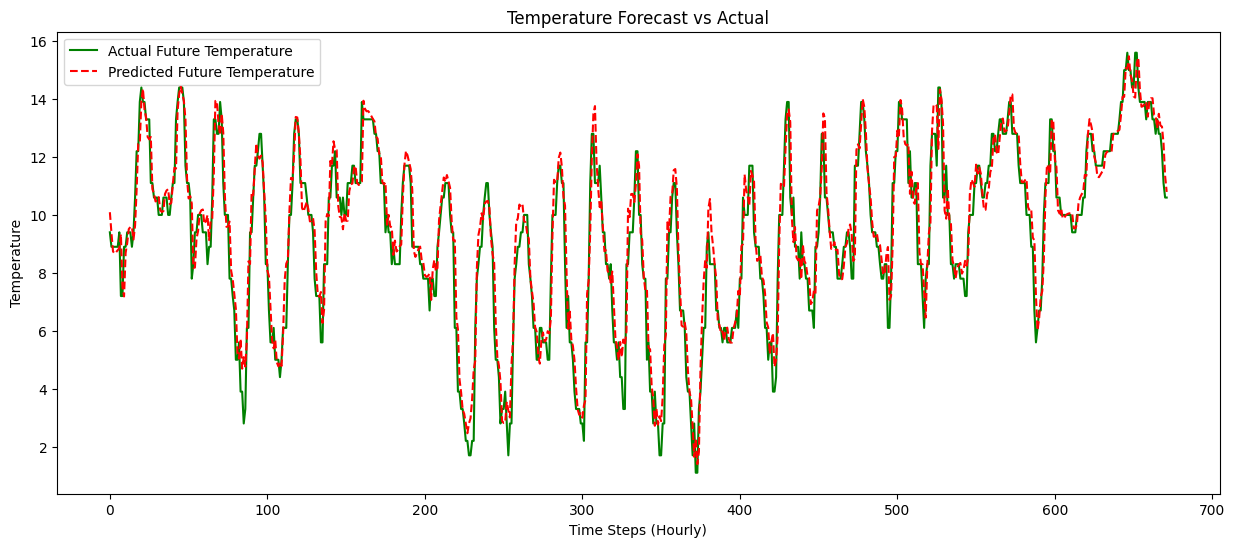

In [20]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test.to('cuda'))

test_pred = test_pred.cpu()
seq = seq.cpu()
# Inverse transform if needed
actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
predicted = scaler.inverse_transform(test_pred.numpy().reshape(-1, 1))
# past = scaler.inverse_transform(seq.numpy().reshape(-1, 1))

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(15, 6))
# plt.plot(range(48), past, label='Actual Temperature')
plt.plot(range(0, 672), actual, label='Actual Future Temperature', color='green')
plt.plot(range(0, 672), predicted, label='Predicted Future Temperature', linestyle='--', color='red')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Time Steps (Hourly)')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Just simple LSTM with 1 city can achieve around 0.02 MAE, now we try to add in more cities' data

In [21]:
fresno_df['Temperature'] = scaler.fit_transform(fresno_df['Temperature'].values.reshape(-1, 1))
ps_df['Temperature'] = scaler.fit_transform(ps_df['Temperature'].values.reshape(-1, 1))

In [22]:
combined_df = ps_df.join(fresno_df, how='outer', lsuffix='_ps', rsuffix='_fresno')

In [23]:
combined_df = combined_df.join(sf_df, how='outer', lsuffix='', rsuffix='_sf')

In [24]:
combined_df['Temperature_ps'] = combined_df['Temperature_ps'].fillna(method='bfill', inplace=False)
combined_df['Temperature_fresno'] = combined_df['Temperature_fresno'].fillna(method='bfill', inplace=False)
combined_df.head(5)

,Temperature_ps,Temperature_fresno,Temperature
DateTime,,,
2020-01-01 00:00:00,0.326360,0.349794,0.375979
2020-01-01 01:00:00,0.326360,0.349794,0.375979
2020-01-01 02:00:00,0.303347,0.349794,0.302872
2020-01-01 03:00:00,0.280335,0.349794,0.245431
2020-01-01 04:00:00,0.244770,0.349794,0.245431


In [25]:
combined_df = combined_df.to_numpy()

In [26]:
# Define the split point for training and testing data (let's use 90% of the data for training)
test_size = 24 * 30  # 30 days
train_data = combined_df[:-test_size]
test_data = combined_df[-test_size:]

# Function to create sequences
def create_sequences(data, input_length, prediction_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - prediction_length + 1):
        x = data[i:i + input_length, :]
        y = data[i + input_length:i + input_length + prediction_length, 2]  # Predict next 24 hours for last city - SF
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 48
prediction_length = 1
X_train, y_train = create_sequences(train_data, input_length, prediction_length)
X_test, y_test = create_sequences(test_data, input_length, prediction_length)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=120, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=120, shuffle=False)

In [28]:
input_dim = 3 # 3 cities now
hidden_dim = 32  # Number of hidden states
num_layers = 2  # Number of LSTM layers
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim).to('cuda')

In [29]:
loss_function = nn.L1Loss()  # MAE loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50

for epoch in range(epochs):
    model.train()
    for seq, labels in train_dataloader:
        seq, labels = seq.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 5 == 0 or epoch == 49:
        model.eval()  # Switch to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient computation
            for seq, labels in test_dataloader:
                seq, labels = seq.to('cuda'), labels.to('cuda')
                y_pred = model(seq)
                val_loss = loss_function(y_pred, labels)
                total_val_loss += val_loss.item()

        # Calculate and print average validation loss for this epoch
        avg_val_loss = total_val_loss / len(test_dataloader)
        print(f'Epoch {epoch} - Validation Loss: {avg_val_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([120, 1])) that is different to the input size (torch.Size([120, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([96, 1])) that is different to the input size (torch.Size([96, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([72, 1])) that is different to the input size (torch.Size([72, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Epoch 0 - Validation Loss: 0.1346
Epoch 5 - Validation Loss: 0.1402
Epoch 10 - Validation Loss: 0.1461
Epoch 15 - Validation Loss: 0.1401
Epoch 20 - Validation Loss: 0.1364
Epoch 25 - Validation Loss: 0.1487
Epoch 30 - Validation Loss: 0.1417
Epoch 35 - Validation Loss: 0.1352
Epoch 40 - Validation Loss: 0.1436
Epoch 45 - Validation Loss: 0.1424
Epoch 49 - Validation Loss: 0.1409


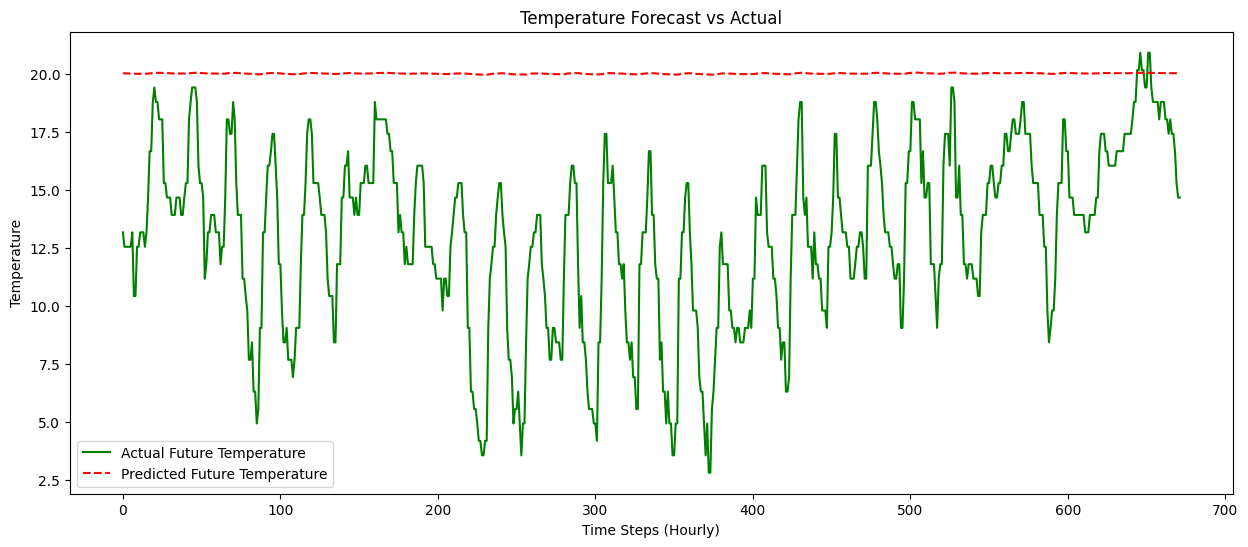

In [30]:
model.eval()
with torch.no_grad():
    test_pred = model(X_test.to('cuda'))

test_pred = test_pred.cpu()
seq = seq.cpu()
# Inverse transform if needed
actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
predicted = scaler.inverse_transform(test_pred.numpy().reshape(-1, 1))
# past = scaler.inverse_transform(seq.numpy().reshape(-1, 1))

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(15, 6))
# plt.plot(range(48), past, label='Actual Temperature')
plt.plot(range(0, 672), actual, label='Actual Future Temperature', color='green')
plt.plot(range(0, 672), predicted, label='Predicted Future Temperature', linestyle='--', color='red')
plt.title('Temperature Forecast vs Actual')
plt.xlabel('Time Steps (Hourly)')
plt.ylabel('Temperature')
plt.legend()
plt.show()

We can see SARIMAX with multiple cities is just prediciting a straight line here, not helpful...

### Graph Convolustion + LSTM

Please see the separate notebook for it